In [8]:
import os

import cupy as xp
from gw_functions.mass_prior_v1 import MassPrior
import numpy as np
import matplotlib.pyplot as plt
# mass_prior = MassPrior(population_parameters)

In [2]:
N = 100000  # Total number of samples
Nselect = 1
# beta = xp.array([0.81]*N)
# alpha = xp.array([3.78]*N)
# mmin = xp.array([4.98]*N)
# mmax = xp.array([250]*N)
# mu_g = xp.array([32.27]*N)
# sigma_g = xp.array([6.76]*N)
# lambda_peak = xp.array([0.1]*N)
# delta_m = xp.array([4.8]*N)
# lambda_peak2 = xp.array([0.66]*N)
# mu_g2 = xp.array([10]*N)
# sigma_g2 = xp.array([3]*N)


# Set all parameters as uniform priors
beta = xp.random.uniform(-4, 12, N) 
alpha = xp.random.uniform(1.5, 12, N) 
mmin = xp.random.uniform(5, 10, N) 
mmax = xp.random.uniform(50, 200, N) 
sigma_g = xp.random.uniform(0.4, 10.0, N)  
lambda_peak = xp.random.uniform(0.0, 1.0, N)  
delta_m = xp.random.uniform(4.0, 6.0, N) 
lambda_peak2 = xp.random.uniform(0, 1.0, N) 
sigma_g2 = xp.random.uniform(0.4, 10.0, N) 


mu_g_sample = xp.random.uniform(5, 100, N)  # Generate samples for mu_g
mu_g2_sample = xp.random.uniform(5, 100, N)  # Generate samples for mu_g2

# Swap values where mu_g < mu_g2
inx_switch = xp.where(mu_g_sample < mu_g2_sample)
# Swap values to ensure mu_g > mu_g2
mu_g = mu_g_sample.copy()
mu_g2 = mu_g2_sample.copy()
mu_g[inx_switch], mu_g2[inx_switch] = mu_g2[inx_switch], mu_g[inx_switch]

# Sampling m1
population_parameters = {
    'beta': beta, # Uniform distribution: [0.81]*N
    'alpha': alpha, # Uniform distribution: [3.78]*N
    'mmin': mmin, # Uniform distribution: [4.98]*N
    'mmax': mmax, # Uniform distribution: [100]*N
    'mu_g': mu_g, # Uniform distribution: [32.27]*N
    'sigma_g': sigma_g, # Uniform distribution: [3.88]*N
    'lambda_peak': lambda_peak, # Uniform distribution: [0.03]*N
    'delta_m': delta_m, # Uniform distribution: [4.8]*N
    'lambda_peak2':lambda_peak2,
    'mu_g2':mu_g2,
    'sigma_g2':sigma_g2,
    'name': 'BBH-powerlaw-gaussian' # Uniform distribution: BBH-powerlaw-gaussian (as a label)
}
mass_prior = MassPrior(population_parameters, mgrid = 250)


5.531580659217251
8.120485555664827
0.2385581148044305
0.3823350003783276


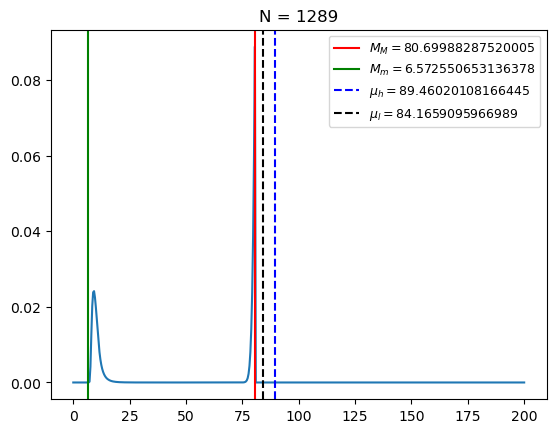

In [9]:
pdfs_m1 = mass_prior.powerlaw_plus_peak_smooth_2gaussian_vect(mass_prior.m_vect)
n = np.random.randint(N)
plt.title('N = {}'.format(n))
plt.plot(mass_prior.m_vect.get(), pdfs_m1[n,:].get())
plt.axvline(mmax[n].get(), color = 'red', label = r'$M_M = {}$'.format(mmax[n].get()))
plt.axvline(mmin[n].get(), color = 'green', label = r'$M_m = {}$'.format(mmin[n].get()))
plt.axvline(mu_g[n].get(), color = 'b', linestyle = 'dashed', label = r'$\mu_h = {}$'.format(mu_g[n].get()))
plt.axvline(mu_g2[n].get(), color = 'k', linestyle = 'dashed', label = r'$\mu_l = {}$'.format(mu_g2[n].get()))
plt.legend(fontsize = 9)

computing p(m1,m2) cdfs


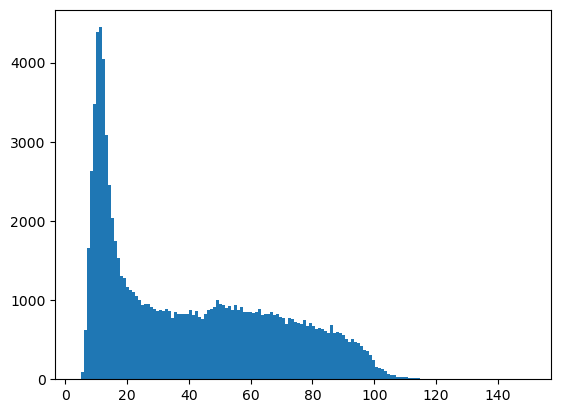

In [3]:
print('computing p(m1,m2) cdfs')
cdfs_m1 = mass_prior.make_cdfs(log_space = False , pdf_function = mass_prior.powerlaw_plus_peak_smooth_2gaussian_vect)
m1 = mass_prior.draw_m(Nsamples = Nselect, cdfs = cdfs_m1)
# Correct in one efficient step
epsilon = xp.array(1e-5)
m1 = xp.maximum(xp.array(m1), mmin+epsilon)
# valid_samples = xp.array(xp.array(m1) >= mmin)
# while not xp.all(valid_samples):
    
#     invalid_indices = xp.where(~valid_samples)[0]
#     print(invalid_indices)
#     new_samples = mass_prior.draw_m(1, cdfs_m1[invalid_indices // 1, :])
#     m1[invalid_indices.get()] = new_samples
#     valid_samples = xp.array((xp.array(m1) >=mmin))

import matplotlib.pyplot as plt
_ = plt.hist(m1.get(), bins = 150, range = (4,150))
# plt.axvline(mmin[0].get(),color = 'red')

In [4]:
cdfs_m2 = mass_prior.make_cdfs_m2(xp.array(m1))
m_vect_m2 = xp.linspace(0, m1[:, None], mass_prior.mgrid, axis=1)
m_vect_m2 = xp.reshape(m_vect_m2, (len(m1), mass_prior.mgrid))
m2 = mass_prior.draw_m(1, cdfs_m2, m2_arr = xp.hstack(m_vect_m2))

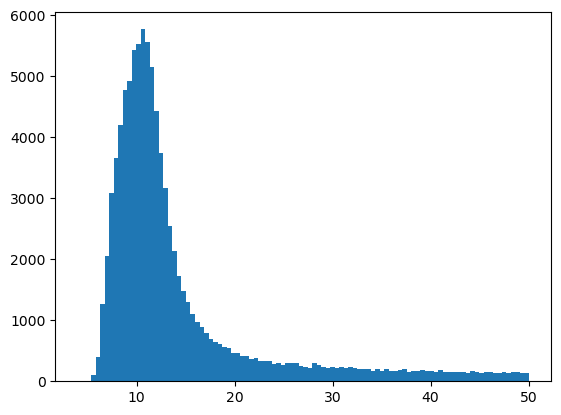

In [5]:
_ = plt.hist(m2, bins = 100, range = (4,50))

In [6]:
import numpy as np
inx_bad = np.where(np.isnan(m2))[0]
m1.get()[inx_bad] - mmin.get()[inx_bad]

array([], dtype=float64)

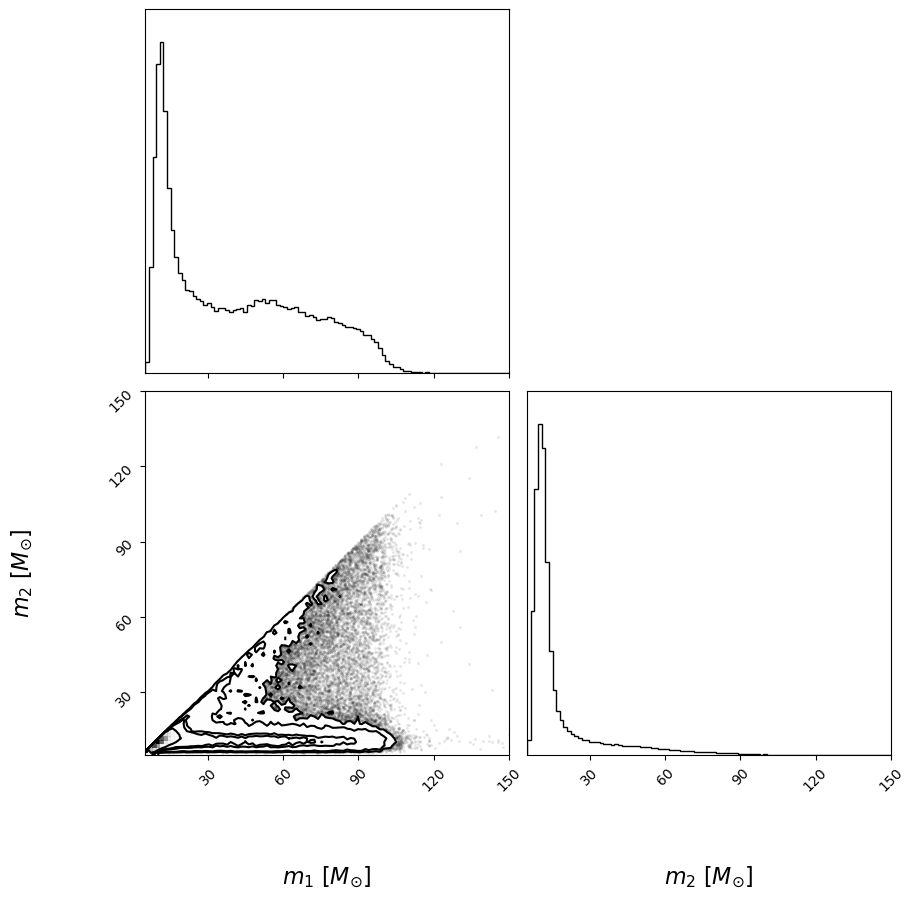

In [54]:
import corner
import pandas as pd

# Create a DataFrame from m1 and m2
data = pd.DataFrame({'m1': m1.get(), 'm2': m2})

# Generate a corner plot with increased bins and adjusted plot size
fig = corner.corner(data, 
                    range=[(4.98, 150), (4.98, 150)],  # Set range for both axes
                    bins=100,                           # Increase bin count to 100 for more detailed bins
                    labels=["$m_1$ [$M_{\odot}$]", "$m_2$ [$M_{\odot}$]"],  # Add axis labels with units
                    smooth=0,                          # Apply smoothing to contours for better visual clarity
                    levels=(0.3, 0.5, 0.6, 0.8, 0.9),  # Set levels for contours
                    label_kwargs={'fontsize': 16},     # Set label font size for readability
                    title_kwargs={'fontsize': 14},     # Set title font size (if any)
                    plot_density=True,                 # Enable density plots
                    plot_contours=True,                # Enable contours
                    hist_2dkwargs={'bins': 100})         # Set bins for the histograms

# Increase the size of the figure directly after generating it
fig.set_size_inches(10, 10)  # Increase dimensions for a better view of increased bins
# fig.tight_layout()  # Ensure tight layout so nothing overlaps

# Show the plot
fig.show()


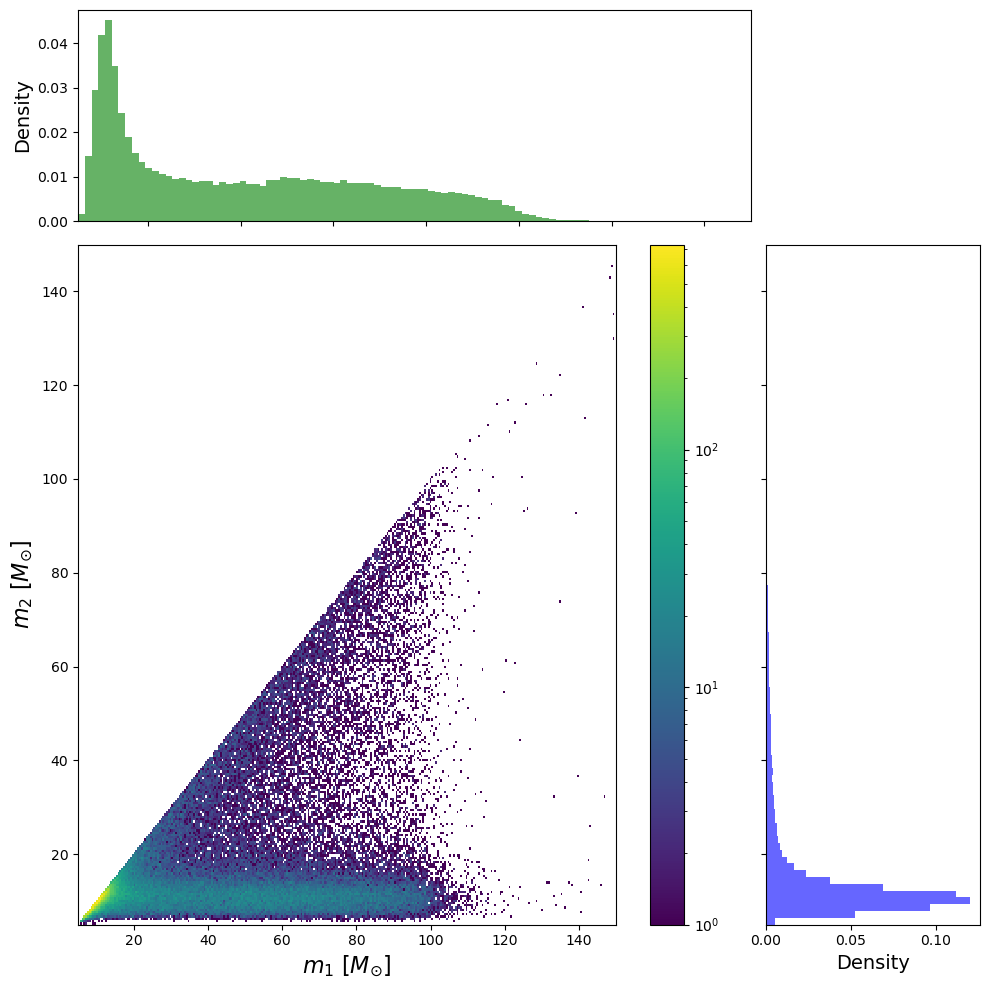

In [13]:
from matplotlib.colors import LogNorm
# Set up the main plot and margin plots
fig = plt.figure(figsize=(8, 8))

# Define gridspec layout
from matplotlib import gridspec
gs = gridspec.GridSpec(4, 4, figure=fig)
main_ax = fig.add_subplot(gs[1:4, 0:3])  # Main 2D histogram
bottom_hist_ax = fig.add_subplot(gs[0, 0:3], sharex=main_ax)  # Bottom histogram for m1
left_hist_ax = fig.add_subplot(gs[1:4, 3], sharey=main_ax)  # Left histogram for m2

# 2D Histogram (Heatmap) with normalization and log scale
hb = main_ax.hist2d(data['m1'], data['m2'], bins=300, range=[[4.98, 150], [4.98, 150]], cmap='viridis', norm=LogNorm())
fig.colorbar(hb[3], ax=main_ax, orientation='vertical')

# Marginal histograms for m1 and m2 (normalized)
bottom_hist_ax.hist(data['m1'], bins=100, range=(4.98, 150), color='green', alpha=0.6, density=True)
left_hist_ax.hist(data['m2'], bins=100, range=(4.98, 150), color='blue', alpha=0.6, orientation='horizontal', density=True)

# Hide tick labels for the marginal histograms
bottom_hist_ax.tick_params(labelbottom=False)
left_hist_ax.tick_params(labelleft=False)

# Set labels for the main plot and histograms
main_ax.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize=16)
main_ax.set_ylabel(r"$m_2$ [$M_{\odot}$]", fontsize=16)
bottom_hist_ax.set_ylabel('Density', fontsize=14)
left_hist_ax.set_xlabel('Density', fontsize=14)

plt.tight_layout()
plt.show()




In [1]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Number of CUDA devices:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")


CUDA Available: True
Number of CUDA devices: 2
Device 0: NVIDIA A100-PCIE-40GB
Device 1: NVIDIA GeForce RTX 3080


In [6]:
import torch

print(f"PyTorch CUDA Version: {torch.version.cuda}")
print(f"Is CUDA available? {torch.cuda.is_available()}")


PyTorch CUDA Version: None
Is CUDA available? False


In [5]:
import torch

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version Used by PyTorch: {torch.version.cuda}")
print(f"Is CUDA Available? {torch.cuda.is_available()}")


PyTorch Version: 2.5.1
CUDA Version Used by PyTorch: None
Is CUDA Available? False


In [24]:
# import cupy as xp

# def make_cdfs_m2_chunked(m1, chunk_size=100, m_array_long=None, prior_pdf=None, 
#                          population_parameters=None):
#     """
#     Compute the CDFs for m2 in smaller chunks to avoid memory errors.

#     Args:
#         m1 (cupy.ndarray): Primary mass values.
#         chunk_size (int): Size of each chunk.
#         m_array_long (cupy.ndarray, optional): Long array of mass values.
#         prior_pdf (cupy.ndarray, optional): Prior probability density function.
#         population_parameters (dict, optional): Dictionary of population parameters.

#     Returns:
#         cupy.ndarray: CDF values.
#     """
#     if population_parameters is None:
#         raise ValueError("population_parameters must be provided.")

#     cdf_list = []

#     for i in range(0, len(m1), chunk_size):
#         m1_chunk = xp.array(m1)[i:i + chunk_size]
#         beta_chunk = population_parameters['beta'][i:i + chunk_size]
#         mmin_chunk = population_parameters['mmin'][i:i + chunk_size]
#         delta_m_chunk = population_parameters['delta_m'][i:i + chunk_size]

#         # Expand dimensions to align properly with m_vect_m2
#         m1_chunk_expanded = xp.expand_dims(m1_chunk, axis=1)  # Shape (chunk_size, 1)
#         beta_chunk_expanded = xp.expand_dims(beta_chunk, axis=1)
#         mmin_chunk_expanded = xp.expand_dims(mmin_chunk, axis=1)
#         delta_m_chunk_expanded = xp.expand_dims(delta_m_chunk, axis=1)
        
#         # Create m_vect_m2 that ends at m1_chunk for each primary mass
#         m_vect_m2 = xp.linspace(0, m1_chunk_expanded, mass_prior.mgrid, axis=-1)  # Shape (chunk_size, mgrid)


#         if prior_pdf is None:
#             if m_array_long is None:
#                 pdf = mass_prior.powerlaw_smooth_m2_vect(m_vect_m2, m1_chunk, beta=beta_chunk,
#                                                          mmin=mmin_chunk, delta_m=delta_m_chunk)
#             else:
#                 pdf = mass_prior.powerlaw_smooth_m2_vect(m_array_long, m1_chunk, beta=beta_chunk,
#                                                          mmin=mmin_chunk, delta_m=delta_m_chunk)
#         else:
#             pdf = prior_pdf[i:i + chunk_size]

#         cdf = xp.cumsum(pdf, axis=1)
#         cdf_maximum = xp.amax(cdf, axis=1)[:, None]
#         cdf_normalized = cdf / cdf_maximum
        
#         cdf_list.append(cdf_normalized)
    
#     return xp.concatenate(cdf_list, axis=0)

# # Example usage
# m2_cdfs = make_cdfs_m2_chunked(m1, population_parameters=population_parameters)
